# Vision Transformer (ViT) for Cotton Leaf Disease Classification

## Data Prepration

In [1]:
# imports and setup
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [2]:
# Device, Paths, and Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dir = 'd:/EfficientNet/Cotton_Dataset/train'
val_dir = 'd:/EfficientNet/Cotton_Dataset/val'
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 10

### Data Augmentation and Data Loaders

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.0)),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

def create_dataloaders(train_dir, val_dir, train_transform, val_transform, batch_size):
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    val_data = datasets.ImageFolder(val_dir, transform=val_transform)
    class_names = train_data.classes
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, val_loader, class_names

train_loader, val_loader, class_names = create_dataloaders(
    train_dir, val_dir, train_transforms, val_transforms, BATCH_SIZE
)
print("Classes:", class_names)

Classes: ['bacterial_blight', 'curl_virus', 'fussarium_wilt', 'healthy']


## Model Architecture

In [4]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # [B, emb_size, H/patch, W/patch]
        x = x.flatten(2)  # [B, emb_size, N]
        x = x.transpose(1, 2)  # [B, N, emb_size]
        return x

class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_size=768, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.attn = nn.MultiheadAttention(emb_size, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(emb_size)
        self.mlp = nn.Sequential(
            nn.Linear(emb_size, int(emb_size * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(emb_size * mlp_ratio), emb_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x2 = self.norm1(x)
        attn_out, _ = self.attn(x2, x2, x2)
        x = x + attn_out
        x2 = self.norm2(x)
        x = x + self.mlp(x2)
        return x

class ViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=4, emb_size=768, depth=6, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, emb_size, img_size)
        n_patches = self.patch_embed.n_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_size))
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches + 1, emb_size))
        self.encoders = nn.Sequential(*[
            TransformerEncoderBlock(emb_size, num_heads, mlp_ratio, dropout) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(emb_size)
        self.head = nn.Linear(emb_size, num_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.encoders(x)
        x = self.norm(x)
        cls_out = x[:, 0]
        return self.head(cls_out)

model = ViT(img_size=IMG_SIZE, patch_size=16, in_channels=3, num_classes=NUM_CLASSES, emb_size=256, depth=6, num_heads=8, mlp_ratio=4.0, dropout=0.1).to(device)
print(model)

ViT(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
  )
  (encoders): Sequential(
    (0): TransformerEncoderBlock(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=1024, out_features=256, bias=True)
        (4): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderBlock(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2):

In [5]:
# Loss, Optimizer, and Training utilities
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

## Training and Validation

In [6]:
# Training and Validation Loop with Metrics Tracking
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, running_corrects, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += (preds == labels).sum().item()
        total += labels.size(0)
    train_losses.append(running_loss / total)
    train_accs.append(running_corrects / total)

    model.eval()
    val_loss, val_corrects, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_losses.append(val_loss / val_total)
    val_accs.append(val_corrects / val_total)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Train Acc: {train_accs[-1]:.4f} | Val Acc: {val_accs[-1]:.4f}")

d:\EfficientNet\venv\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/10 | Train Loss: 1.4871 | Val Loss: 1.3630 | Train Acc: 0.2921 | Val Acc: 0.4135
Epoch 2/10 | Train Loss: 1.3210 | Val Loss: 1.2777 | Train Acc: 0.3598 | Val Acc: 0.4311
Epoch 3/10 | Train Loss: 1.0215 | Val Loss: 0.8424 | Train Acc: 0.5614 | Val Acc: 0.6217
Epoch 4/10 | Train Loss: 0.9289 | Val Loss: 0.7336 | Train Acc: 0.6034 | Val Acc: 0.7067
Epoch 5/10 | Train Loss: 0.7572 | Val Loss: 0.7113 | Train Acc: 0.6954 | Val Acc: 0.6745
Epoch 6/10 | Train Loss: 0.7064 | Val Loss: 0.6288 | Train Acc: 0.7020 | Val Acc: 0.7155
Epoch 7/10 | Train Loss: 0.7779 | Val Loss: 0.7467 | Train Acc: 0.6740 | Val Acc: 0.6891
Epoch 8/10 | Train Loss: 0.6347 | Val Loss: 0.6967 | Train Acc: 0.7432 | Val Acc: 0.7038
Epoch 9/10 | Train Loss: 0.6328 | Val Loss: 0.5389 | Train Acc: 0.7535 | Val Acc: 0.7859
Epoch 10/10 | Train Loss: 0.5082 | Val Loss: 0.4447 | Train Acc: 0.8065 | Val Acc: 0.8299


## Results: Accuracy and Loss Curves

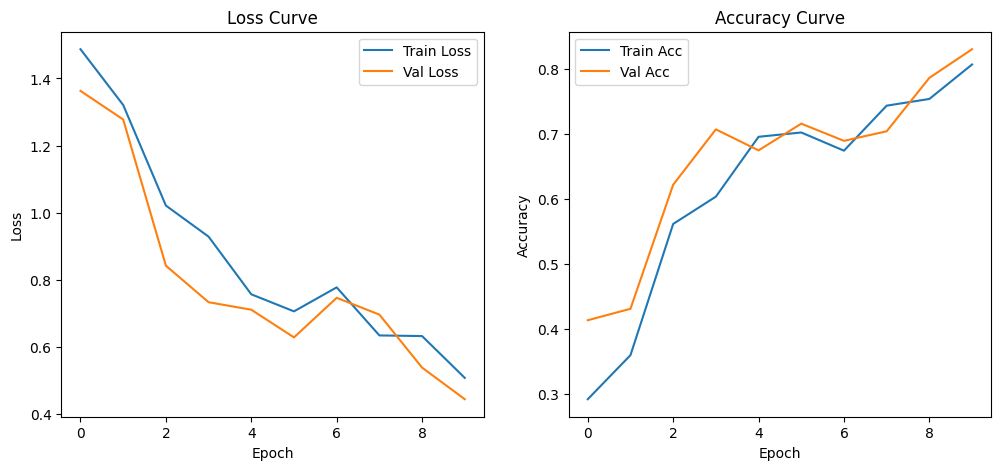

In [8]:
# Plot Training and Validation Curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

## Confusion Matrix and Prediction Visualization

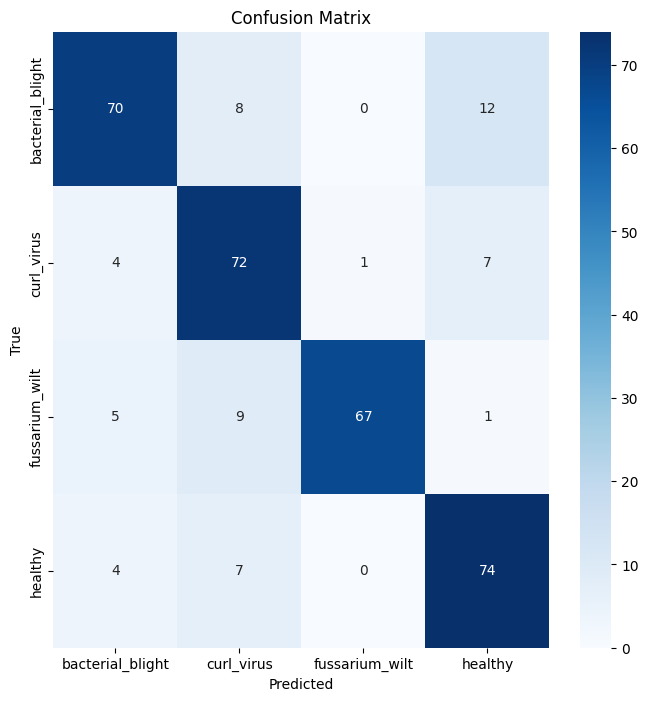

In [7]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Example Predictions

d:\EfficientNet\venv\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


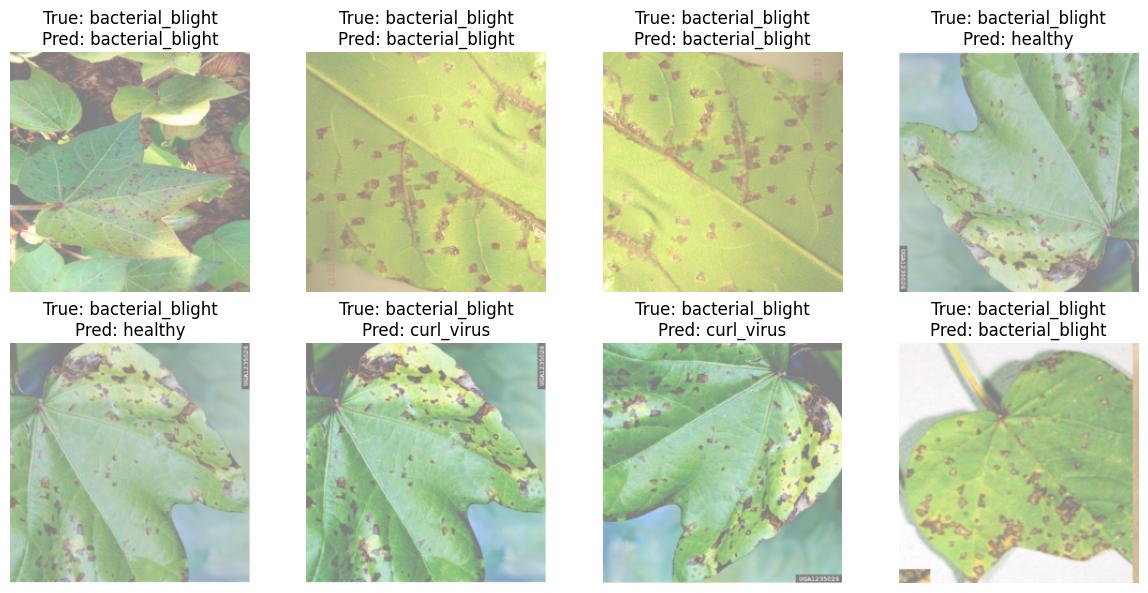

In [9]:
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    mean, std = np.array([0.5]*3), np.array([0.5]*3)
    img = np.clip(img * std + mean, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(12,6))
for idx in range(8):
    plt.subplot(2,4,idx+1)
    imshow(images[idx].cpu(), f"True: {class_names[labels[idx]]}\nPred: {class_names[preds[idx]]}")
plt.tight_layout()
plt.show()

## Prediction with image path

In [17]:
# Use the same transform as your validation set (val_transforms)
from PIL import Image

def predict_image(image_path, model, class_names, transform, device='cpu'):
    """
    Predict the class of an image given its file path.
    """
    model.eval()
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        outputs = model(img_tensor)
        _, pred = torch.max(outputs, 1)
        predicted_class = class_names[pred.item()]
        probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]
    print(f"Predicted class: {predicted_class}")
    for i, cls in enumerate(class_names):
        print(f"{cls}: {probs[i]*100:.2f}%")
    # Show image with prediction
    plt.imshow(image)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()
    return predicted_class

Predicted class: curl_virus
bacterial_blight: 0.38%
curl_virus: 84.05%
fussarium_wilt: 0.25%
healthy: 15.32%


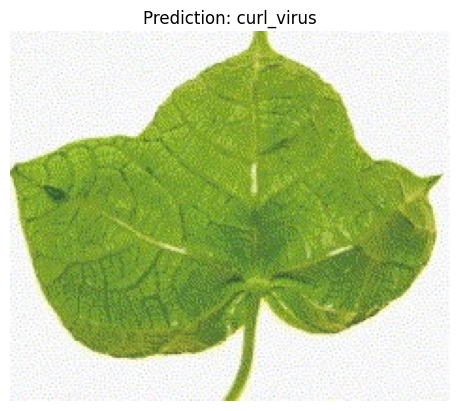

'curl_virus'

In [18]:
image_path = r"D:\EfficientNet\Cotton_Dataset\train\curl_virus\curl00.jpg"
predict_image(image_path, model, class_names, val_transforms, device)